In [1]:
%reset -fs

In [36]:
import pandas as pd
from xgboost import XGBRegressor
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [3]:
diamond_df = pd.read_csv('diamonds.csv', index_col=0)

In [4]:
diamond_df.head(20)

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
6,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48
7,0.24,Very Good,I,VVS1,62.3,57.0,336,3.95,3.98,2.47
8,0.26,Very Good,H,SI1,61.9,55.0,337,4.07,4.11,2.53
9,0.22,Fair,E,VS2,65.1,61.0,337,3.87,3.78,2.49
10,0.23,Very Good,H,VS1,59.4,61.0,338,4.00,4.05,2.39


In [5]:
diamond_df.shape

(53940, 10)

In [6]:
diamond_df.isna().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [7]:
diamond_df.dtypes

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object

In [8]:
diamond_df.cut.value_counts()

Ideal        21551
Premium      13791
Very Good    12082
Good          4906
Fair          1610
Name: cut, dtype: int64

In [9]:
diamond_df.color.value_counts()

G    11292
E     9797
F     9542
H     8304
D     6775
I     5422
J     2808
Name: color, dtype: int64

In [10]:
diamond_df.clarity.value_counts()

SI1     13065
VS2     12258
SI2      9194
VS1      8171
VVS2     5066
VVS1     3655
IF       1790
I1        741
Name: clarity, dtype: int64

In [12]:
diamond_df.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [13]:
diamond_df = diamond_df.drop(diamond_df[diamond_df["x"]==0].index)
diamond_df = diamond_df.drop(diamond_df[diamond_df["y"]==0].index)
diamond_df = diamond_df.drop(diamond_df[diamond_df["z"]==0].index)

In [14]:
diamond_df = diamond_df[diamond_df['depth'] < diamond_df['depth'].quantile(0.99)]
diamond_df = diamond_df[diamond_df['table'] < diamond_df['table'].quantile(0.99)]
diamond_df = diamond_df[diamond_df['x'] < diamond_df['x'].quantile(0.99)]
diamond_df = diamond_df[diamond_df['y'] < diamond_df['y'].quantile(0.99)]
diamond_df = diamond_df[diamond_df['z'] < diamond_df['z'].quantile(0.99)]

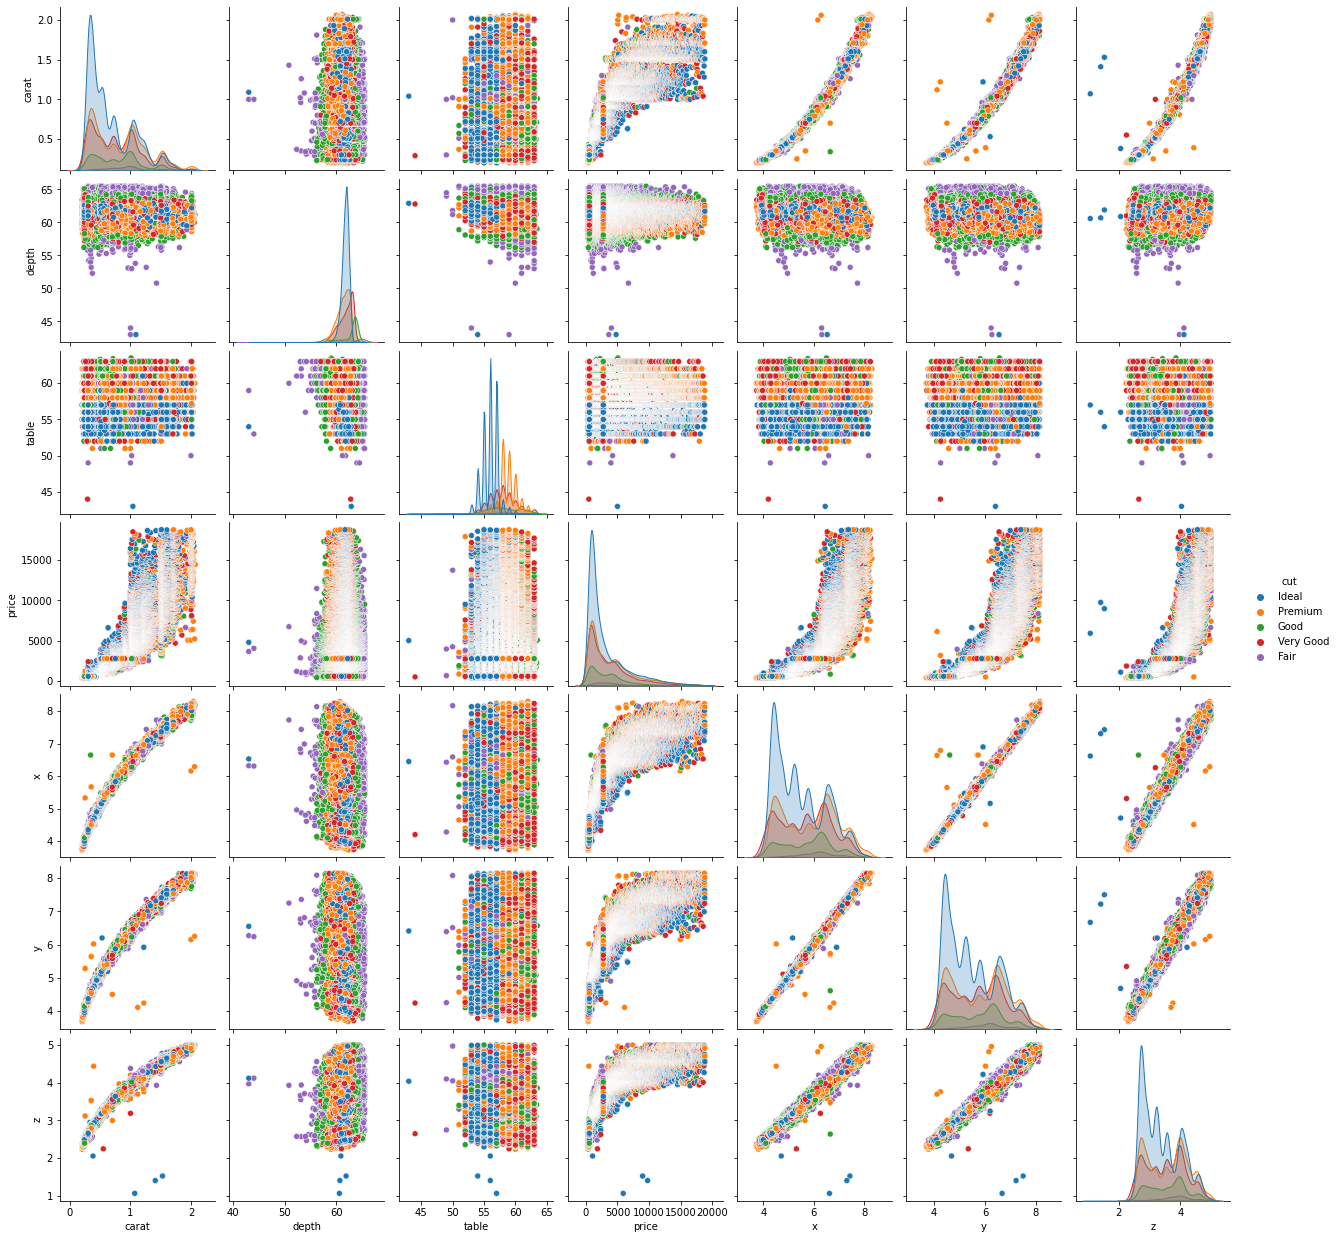

In [15]:
sns.pairplot(diamond_df, hue='cut')

In [16]:
s = (diamond_df.dtypes =="object")
object_cols = list(s[s].index)
print("Categorical variables:")
print(object_cols)

Categorical variables:
['cut', 'color', 'clarity']


In [19]:
model_df = diamond_df.copy()

# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for col in object_cols:
    model_df[col] = label_encoder.fit_transform(model_df[col])
model_df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,2,1,3,61.5,55.0,326,3.95,3.98,2.43
2,0.21,3,1,2,59.8,61.0,326,3.89,3.84,2.31
4,0.29,3,5,5,62.4,58.0,334,4.20,4.23,2.63
5,0.31,1,6,3,63.3,58.0,335,4.34,4.35,2.75
6,0.24,4,6,7,62.8,57.0,336,3.94,3.96,2.48


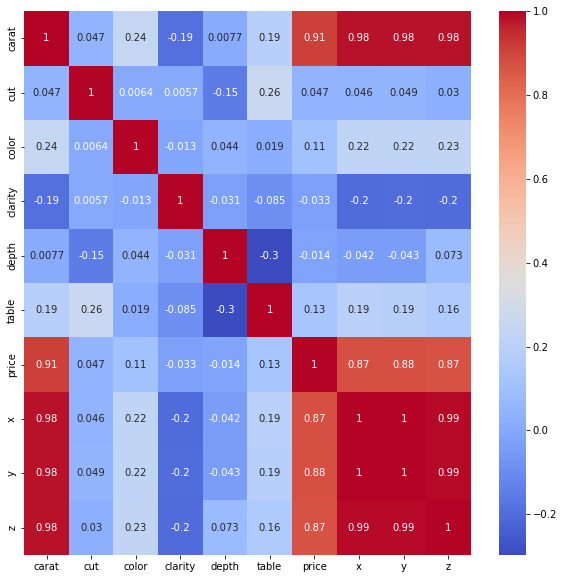

In [24]:
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(model_df.corr(), annot=True, cmap='coolwarm');

In [25]:
X = model_df.drop(['price'], axis=1)
y = model_df['price']

In [26]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [27]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=0)

In [28]:
xgb1 = XGBRegressor()
parameters = {
              'objective':['reg:squarederror'],
              'learning_rate': [.0001, 0.001, .01],
              'max_depth': [3, 5, 7],
              'min_child_weight': [3,5,7],
              'subsample': [0.1,0.5,1.0],
              'colsample_bytree': [0.1, 0.5, 1.0],
              'n_estimators': [500]}

In [29]:
xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 3,
                        n_jobs = -1,
                        verbose=True)

In [30]:
xgb_grid.fit(X_train, y_train)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


c:\Users\nated\anaconda3\envs\metis\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n...
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    val

In [31]:
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

0.9817303532670278
{'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 500, 'objective': 'reg:squarederror', 'subsample': 0.5}


In [32]:
xgb_cv = (xgb_grid.best_estimator_)

In [33]:
eval_set = [(X_train, y_train),
            (X_val, y_val)]

In [34]:
fit_model = xgb_cv.fit(
    X_train,
    y_train,
    eval_set=eval_set,
    eval_metric='mae',
    early_stopping_rounds=50,
    verbose=False)

In [37]:
print("MAE:", mean_absolute_error(y_val, fit_model.predict(X_val)))
print("MSE:", mean_squared_error(y_val, fit_model.predict(X_val)))
print("R2:", r2_score(y_val, fit_model.predict(X_val)))

MAE: 243.00297065613998
MSE: 208836.76587110077
R2: 0.9824771857631683


c:\Users\nated\anaconda3\envs\metis\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
c:\Users\nated\anaconda3\envs\metis\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
c:\Users\nated\anaconda3\envs\metis\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
